# Determining the FOFB Controls Efforts in Sirius as Input for RTM-LAMP Tests

Three scripts were developed in order to calculate the current inputs for RTM-LAMP tests. Each one will be hereby addressed in the following subsections.

## Response Matrix Calculation: calc_respmat_fofb.py (from Fernando H. de Sá) 
Must be ran locally at Sirius Operation Room. calculates the response matrix in um/urad from the machine model and it is organized as folows:

\begin{bmatrix}
    M_{xx}       & M_{xy} \\
    M_{yx}       & M_{yy} 
\end{bmatrix}

where

\begin{matrix}
    M_{xx} = FCH~BPM_x \\ 
    M_{xy} = FCV~BPM_x \\
    M_{yx} = FCH~BPM_y \\
    M_{yy} = FCV~BPM_y
\end{matrix}

which means the dimension of M is (320, 160). 

The resulting matrix was stored in \textit{Rmat.pickle} and \textit{Rmat.mat} files.

## BPM Readings Acquisition: bpm_mult_acq.py

This script loads BPM PVs whose names are in bpmlist.pickle (default) and dumps bpm readings in [[x],[y]]
format to the 'results' (default) .pickle and .mat files. Shape is $2~n_{BPMs} \times n_{samples}$. Units in nm.

As example of usage, first readings were performed on 22-Feb-2021. 100k samples were acquired in FOFB channel an the results dumped in test100k.mat and test100k.pickle files by running:

```bash
    ./bpm_mult_acq.py 100000 'FOFB' -r 'test100k'
```

## Fast Correctors Current Estimations: calc_i_FCOR.py

This script inputs \textit{acqfile} string and loads bpm readings from aqcfile+'.pickle' and the response 
matrix present in 'Rmat.pickle' file.

After calculating the pseudoinverse of Rmat through SVD, the current response is obtained from 
\begin{equation}
    I_{FCOR} = \frac{1}{kick_{factor}} R_{pseudoinv} \cdot xy_{readings}
\end{equation}

with $kick_{factor} = 0.03~ \mu rad/mA $

Results in time domain are dumped to acqfile+'i_FCOR.pickle' acqfile+'i_FCOR.mat' in mA.

### 22-Feb-2021
The code below is mostly from calc_i_FCOR.py and calculates FFT for FOFB acq channel and 100k samples provides:



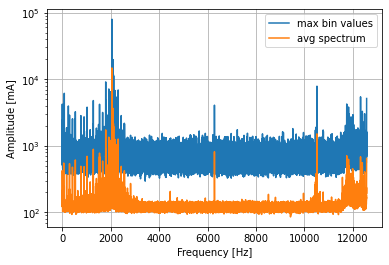

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

acqfile = 'test100k'

with open('Rmat.pickle', 'rb') as filehandle:
    Rmat = pickle.load(filehandle)    # [um/urad]
    
U, s, Vt = np.linalg.svd(Rmat)

threshold = 1e-5

s_inv = np.array([1/i if i > threshold else 0. for i in s])

W_inv = np.zeros((len(Vt), len(U))) #, dtype=complex)
W_inv[:len(Vt), :len(Vt)] = np.diag(s_inv)

R_pseudoinv = np.linalg.multi_dot([np.transpose(Vt), W_inv, np.transpose(U)])

fRF = 499.6649e6

fFOFB = fRF/19872
wFOFB = 2*np.pi*fFOFB

Ts = 1/fFOFB

with open(acqfile + '.pickle', 'rb') as filehandle2:
    xy_read = pickle.load(filehandle2)*1e-3

_,ns = xy_read.shape

kick_factor = 0.03 # urad/mA
corr_signals = R_pseudoinv @ xy_read/kick_factor 

# FFT of the results

freqs = np.fft.fftfreq(ns)*fFOFB
mask = freqs > 0  # list with indexes 

cur_spectra =  np.array( [ 2.0*np.abs(np.fft.fft(corr_signals[i])/ns) for i in range(len(R_pseudoinv)) ] )

# mean and max collumn-wise (i.e. for each fft bin)
cur_mean = np.mean(cur_spectra,axis=0)
cur_max = np.max(cur_spectra,axis=0)

plt.figure(1)

plt.plot(freqs[mask],cur_max[mask],label="max bin values")
plt.plot(freqs[mask],cur_mean[mask],label="avg spectrum")

plt.legend()
plt.yscale('log')
plt.ylabel('Amplitude [mA]')
plt.xlabel('Frequency [Hz]')
plt.grid(True)
plt.show()

The code was debugged and the results evaluated together with MATLAB codes developed by Daniel Tavares.